In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV


## Load the data

In [ ]:
train_df = pd.read_csv("/Users/lydiaelias/Desktop/kaggle/input/train.csv")
test_df = pd.read_csv("/Users/lydiaelias/Desktop/kaggle/input/test.csv")

These files have 'text' associated to the tweet and 'target' as the label. Target values are 0 if not a disaster tweet, 1 if it is.

## Clean tweets

In [5]:
train_df["cleantext"] = train_df["text"].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ")
train_df["cleantext"] = train_df["cleantext"].apply(lambda x: x.lower())
stop_words = stopwords.words('english')
tokenized = train_df["cleantext"].apply(lambda x: x.split())
tokenized = tokenized.apply(lambda x: [item for item in x if item not in stop_words])
detokenized = []
for i in range(len(train_df)):
    t = ' '.join(tokenized[i])
    detokenized.append(t)
train_df["cleantext"] = detokenized

## Start simple: word count vectorizer with linear ridge classifier

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_df["cleantext"])

model = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(model, train_vectors, train_df["target"], cv=3, scoring="accuracy")

We get 63-69% accuracy. Let's see if we can do better

## TFIDF vectorizer with linear ridge classifier

In [6]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(train_df["cleantext"])

model = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(model, train_vectors, train_df["target"], cv=3, scoring="accuracy")

Better! We now have 67-73% accuracy. Maybe it's time to try a different model

## TFIDF vectorizer with SVC

In [ ]:
model = svm.SVC(kernel='linear',C=1.0)

scores = model_selection.cross_val_score(model, train_vectors, train_df["target"], cv=3, scoring="accuracy")

This does almost exactly the same. Let's stop guessing at models and use a grid search to test them

## Grid search for best model

In [ ]:
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = GridSearchCV(estimator=svm.SVC(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)


Now let's find the scores

## TFIDF with model determined by grid search

In [ ]:
model.fit(train_vectors, train_df["target"])
bestmodel = model.best_estimator_
bestparams = model.best_params_
score=model.best_score_

That does even better! We now have an accuracy of 80% with an SVC model (rbf kernel,C=50,degree=3). We'll use this model from now on.

Additional techniques like ngrams and LSA might help us do even better

### Ngrams

In [ ]:
tfidf_ngram = tfidf_vectorizer(ngram_range=(1,2))
train_vectors = tfidf_ngram.fit_transform(train_df["cleantext"])

scores = (bestmodel, train_vectors, train_df["target"], cv=3, scoring="accuracy")

This reduced scores to 61-67%

### TFIDF and LSA with TruncatedSVD

First we have to determine the number of topics that will optimize accuracy

In [17]:
train_vectors = tfidf_vectorizer.fit_transform(train_df["cleantext"])
scs=[]
for i in range(50,400,25):
    svd_model = TruncatedSVD(n_components=i, algorithm='randomized', n_iter=100)
    train_topics = svd_model.fit_transform(train_vectors)
    scores = model_selection.cross_val_score(svm.SVC(C=50,kernel='rbf',gamma='scale'), train_topics, train_df["target"], cv=3, scoring="accuracy")
    scs.append(np.max(scores))
    

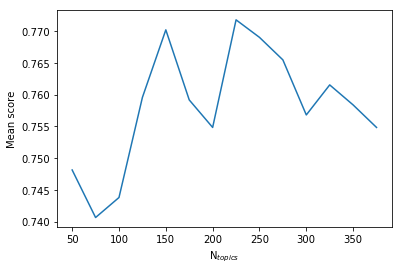

In [18]:
plt.plot(np.linspace(50,375,14),scs)
plt.xlabel('N$_{topics}$')
plt.ylabel('Mean score')

This takes some playing around but ~250 topics seems like a decent number. However, our scores are not markedly better. Let's see why

In [11]:
svd_model = TruncatedSVD(n_components=250, algorithm='randomized', n_iter=100)
svd_model.fit(train_vectors)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
families
 
mh370
 
malaysia
 
confirmed
 
wreckage
 
legionnaires
 
california
 
Topic 1: 
families
 
mh370
 
malaysia
 
wreckage
 
confirmed
 
conclusively
 
pm
 
Topic 2: 
california
 
northern
 
wildfire
 
homes
 
razed
 
latest
 
abc
 
Topic 3: 
get
 
sandstorm
 
swallowed
 
airport
 
minute
 
watch
 
northern
 
Topic 4: 
suicide
 
bomber
 
sandstorm
 
bomb
 
swallowed
 
airport
 
detonated
 
Topic 5: 
disaster
 
obama
 
typhoon
 
devastated
 
declares
 
saipan
 
signs
 
Topic 6: 
legionnaires
 
families
 
outbreak
 
sue
 
fatal
 
affected
 
40
 
Topic 7: 
reddit
 
content
 
legionnaires
 
quarantine
 
offensive
 
disaster
 
families
 
Topic 8: 
oil
 
spill
 
projected
 
may
 
costlier
 
refugio
 
bigger
 
Topic 9: 
atomic
 
hiroshima
 
japan
 
anniversary
 
70
 
still
 
years
 
Topic 10: 
best
 
hot
 
prebreak
 
hijacking
 
waves
 
sound
 
black
 
Topic 11: 
video
 
migrants
 
hundreds
 
rescuers
 
water
 
searching
 
bodies
 
Topic 12: 
via
 
fedex
 
bioterror
 
longer


Taking a look at a few topics, we see that it did a decent job but not perfect. A score of ~70% makes sense.

All in all, best model is TFIDF in conjunction with svm.SVC(C=50,kernel='rbf',gamma='scale',degree=3) for a score of 80% accuracy